In [190]:
import yaml
import random
import json
from pathlib import Path

with open(r'full_text.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    question_answer_data = yaml.load(file, Loader=yaml.FullLoader)


data = []

for i in question_answer_data:
    dat = []
    answer = {}
    dat.append(question_answer_data[i]['context'])
    dat.append(question_answer_data[i]['question'])
    answer['text'] = question_answer_data[i]['answer']
    answer_start = question_answer_data[i]['context'].find(answer['text']);
    answer["answer_start"] = answer_start
    answer["answer_end"] = answer_start + len(question_answer_data[i]['answer'])
    dat.append(answer)
    data.append(dat)

random.shuffle(data)

val_contexts = []
val_questions = []
val_answers = []

train_contexts = []
train_questions = []
train_answers = []

n = 6

for i in range(len(data)):
    if i < n:
        val_contexts.append(data[i][0])
        val_questions.append(data[i][1])
        val_answers.append(data[i][2])
    else:
        train_contexts.append(data[i][0])
        train_questions.append(data[i][1])
        train_answers.append(data[i][2])

In [213]:
count_words = {}

def count_the_words(counts, string):
    words = string.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

for i in train_contexts:
     count_the_words(count_words, i)
for i in val_contexts:
     count_the_words(count_words, i)

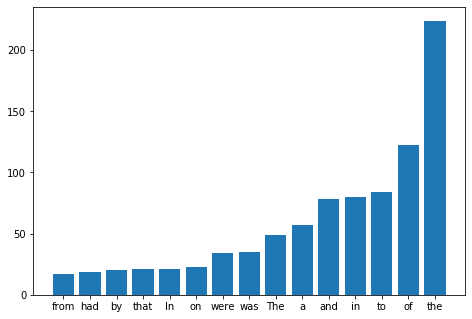

In [215]:
count_words = {k: v for k, v in sorted(count_words.items(), key=lambda item: item[1])}
x = list(count_words.keys())[-15:]
y = [count_words[i] for i in x]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()

In [192]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [193]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [194]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [195]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [196]:
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased")
model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased")

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

In [197]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    print(epoch)
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

print("DONE")

0
1
2


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [204]:
from transformers import pipeline

myModel = pipeline(task = 'question-answering', model = model, tokenizer = tokenizer)
baseModel = pipeline(task = 'question-answering', model = model2, tokenizer = tokenizer)
goodModel = pipeline(task = 'question-answering')

myModelCorrect = 0
goodModelCorrect = 0
for i in range(n):
    myResults = myModel(question = val_questions[i], context = val_contexts[i])
    goodResults = goodModel(question = val_questions[i], context = val_contexts[i])
    print(myResults)
    print(baseModel(question = val_questions[i], context = val_contexts[i]))
    print(goodResults)
    print(val_answers[i]['text'])
    if myResults['answer'] == val_answers[i]['text']:
        myModelCorrect += 1
    if goodResults['answer'] == val_answers[i]['text']:
        goodModelCorrect += 1

print(myModelCorrect)
print(goodModelCorrect)

{'score': 0.005373006220906973, 'start': 151, 'end': 162, 'answer': 'janissaries'}
{'score': 0.0004604584537446499, 'start': 162, 'end': 174, 'answer': '.  Recruited'}
{'score': 0.21019193530082703, 'start': 190, 'end': 211, 'answer': 'Chris-tian population'}
an elite guard
{'score': 0.0025214729830622673, 'start': 217, 'end': 226, 'answer': 'Hand axes'}
{'score': 0.0002752182481344789, 'start': 310, 'end': 344, 'answer': '. Hand axes eventually were set in'}
{'score': 0.9793450832366943, 'start': 477, 'end': 483, 'answer': 'spears'}
spears
{'score': 0.015940193086862564, 'start': 89, 'end': 96, 'answer': 'Assyria'}
{'score': 0.00109293672721833, 'start': 114, 'end': 173, 'answer': '. The Sumerians were the creators of the first Mesopotamian'}
{'score': 0.7701165676116943, 'start': 116, 'end': 129, 'answer': 'The Sumerians'}
Sumerians
{'score': 0.0008520749979652464, 'start': 285, 'end': 324, 'answer': 'Wellington and suffered a bloody defeat'}
{'score': 0.0001992827601497993, 'start':

In [206]:
myModelCorrect = 0
baseModelCorrect = 0
goodModelCorrect = 0

myModelScore = 0
baseModelScore = 0
goodModelScore = 0


for i in range(10):
    data = []

    for i in question_answer_data:
        dat = []
        answer = {}
        dat.append(question_answer_data[i]['context'])
        dat.append(question_answer_data[i]['question'])
        answer['text'] = question_answer_data[i]['answer']
        answer_start = question_answer_data[i]['context'].find(answer['text']);
        answer["answer_start"] = answer_start
        answer["answer_end"] = answer_start + len(question_answer_data[i]['answer'])
        dat.append(answer)
        data.append(dat)

    random.shuffle(data)

    val_contexts = []
    val_questions = []
    val_answers = []

    train_contexts = []
    train_questions = []
    train_answers = []

    n = 6

    for i in range(len(data)):
        if i < n:
            val_contexts.append(data[i][0])
            val_questions.append(data[i][1])
            val_answers.append(data[i][2])
        else:
            train_contexts.append(data[i][0])
            train_questions.append(data[i][1])
            train_answers.append(data[i][2])
    
    add_end_idx(train_answers, train_contexts)
    add_end_idx(val_answers, val_contexts)
    
    train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
    val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
    
    add_token_positions(train_encodings, train_answers)
    add_token_positions(val_encodings, val_answers)
    
    train_dataset = SquadDataset(train_encodings)
    val_dataset = SquadDataset(val_encodings)
    
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased")
    model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-cased")
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.to(device)
    model.train()

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    optim = AdamW(model.parameters(), lr=5e-5)

    for epoch in range(3):
        print(epoch)
        for batch in train_loader:
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            loss.backward()
            optim.step()

    print("DONE")
    
    myModel = pipeline(task = 'question-answering', model = model, tokenizer = tokenizer)
    baseModel = pipeline(task = 'question-answering', model = model2, tokenizer = tokenizer)
    goodModel = pipeline(task = 'question-answering')
    
    for i in range(n):
        myResults = myModel(question = val_questions[i], context = val_contexts[i])
        goodResults = goodModel(question = val_questions[i], context = val_contexts[i])
        baseResults = baseModel(question = val_questions[i], context = val_contexts[i])
        
        myModelScore += myResults['score']
        baseModelScore += baseResults['score']
        goodModelScore += goodResults['score']
        
        print(myResults)
        print(baseResults)
        print(goodResults)
        print(val_answers[i]['text'])
        if myResults['answer'] == val_answers[i]['text']:
            myModelCorrect += 1
        if baseResults['answer'] == val_answers[i]['text']:
            baseModelCorrect += 1
        if goodResults['answer'] == val_answers[i]['text']:
            goodModelCorrect += 1
            
            
print(myModelCorrect)
print(baseModelCorrect)
print(goodModelCorrect)

print(myModelScore/60)
print(baseModelScore/60)
print(goodModelScore/60)            
            

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.009962261654436588, 'start': 8, 'end': 77, 'answer': 'Mahal is widely considered to be the most beautiful building in India'}
{'score': 0.0018205548403784633, 'start': 105, 'end': 106, 'answer': '.'}
{'score': 0.7801871299743652, 'start': 0, 'end': 13, 'answer': 'The Taj Mahal'}
Taj Mahal
{'score': 0.007324736565351486, 'start': 49, 'end': 59, 'answer': 'Çatalhüyük'}
{'score': 0.000472668296424672, 'start': 207, 'end': 276, 'answer': 'such as weapons and jewelry and traded them with neighboring peoples.'}
{'score': 0.9925965666770935, 'start': 161, 'end': 169, 'answer': 'artisans'}
artisans
{'score': 0.0026158979162573814, 'start': 99, 'end': 131, 'answer': 'James Watt,  a Scottish engineer'}
{'score': 0.0004463562509045005, 'start': 261, 'end': 339, 'answer': '.  Before long,  cotton mills using steam engines were found all over Britain.'}
{'score': 0.9936771988868713, 'start': 99, 'end': 109, 'answer': 'James Watt'}
James Watt
{'score': 0.009984852746129036, 's

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.007537568919360638, 'start': 0, 'end': 11, 'answer': 'The country'}
{'score': 0.0004055129538755864, 'start': 252, 'end': 261, 'answer': 'textile ('}
{'score': 0.6006569266319275, 'start': 170, 'end': 185, 'answer': 'farm population'}
farm population
{'score': 0.015033536590635777, 'start': 89, 'end': 96, 'answer': 'Assyria'}
{'score': 0.0009201286011375487, 'start': 120, 'end': 173, 'answer': 'Sumerians were the creators of the first Mesopotamian'}
{'score': 0.7701165676116943, 'start': 116, 'end': 129, 'answer': 'The Sumerians'}
Sumerians
{'score': 0.0022297105751931667, 'start': 207, 'end': 224, 'answer': 'Thirtyfour people'}
{'score': 0.00014074842329137027, 'start': 172, 'end': 197, 'answer': 'the Watts district of Los'}
{'score': 0.9928851127624512, 'start': 274, 'end': 278, 'answer': '1968'}
1968
{'score': 0.006491181440651417, 'start': 252, 'end': 262, 'answer': 'Khrushchev'}
{'score': 0.00016888811660464853, 'start': 252, 'end': 302, 'answer': 'Khrushche

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.004106559325009584, 'start': 124, 'end': 136, 'answer': 'Fort William'}
{'score': 0.0003441997105255723, 'start': 6, 'end': 74, 'answer': 'fighting the French, Clive was also consolidating British control in'}
{'score': 0.8999214768409729, 'start': 217, 'end': 238, 'answer': 'an underground prison'}
an underground prison
{'score': 0.0066388268023729324, 'start': 51, 'end': 56, 'answer': 'Menes'}
{'score': 0.0005916713853366673, 'start': 61, 'end': 122, 'answer': '•NEEZ) united Upper and Lower Egypt into a single kingdom and'}
{'score': 0.6506887674331665, 'start': 156, 'end': 165, 'answer': 'A dynasty'}
dynasty
{'score': 0.001819412223994732, 'start': 214, 'end': 274, 'answer': 'Great Britain, Italy, Denmark, Norway, Portugal, and Iceland'}
{'score': 9.598955512046814e-05, 'start': 589, 'end': 619, 'answer': 'formal military alliance known'}
{'score': 0.7267914414405823, 'start': 627, 'end': 638, 'answer': 'Warsaw Pact'}
Warsaw Pact
{'score': 0.004707206971943378

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.0032728298101574183, 'start': 142, 'end': 157, 'answer': 'Anthropologists'}
{'score': 0.0003849268250633031, 'start': 182, 'end': 220, 'answer': 'fossils to create a picture of peoples'}
{'score': 0.9974045753479004, 'start': 142, 'end': 157, 'answer': 'Anthropologists'}
Anthropologists
{'score': 0.0017523154383525252, 'start': 101, 'end': 180, 'answer': 'British and Belgian cities were home to many industries.  With the steam engine'}
{'score': 0.00031207280699163675, 'start': 265, 'end': 291, 'answer': 'to the cities to find work'}
{'score': 0.5575182437896729, 'start': 0, 'end': 25, 'answer': 'European cities and towns'}
cities and towns
{'score': 0.06350230425596237, 'start': 4, 'end': 13, 'answer': 'Sumerians'}
{'score': 0.0017913678893819451, 'start': 88, 'end': 106, 'answer': 'greatest invention'}
{'score': 0.6172783970832825, 'start': 111, 'end': 124, 'answer': 'their writing'}
writing
{'score': 0.0014046969590708613, 'start': 99, 'end': 131, 'answer': 'J

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.025739619508385658, 'start': 89, 'end': 96, 'answer': 'Assyria'}
{'score': 0.0008085398585535586, 'start': 114, 'end': 173, 'answer': '. The Sumerians were the creators of the first Mesopotamian'}
{'score': 0.7701165676116943, 'start': 116, 'end': 129, 'answer': 'The Sumerians'}
Sumerians
{'score': 0.0026339967735111713, 'start': 48, 'end': 68, 'answer': 'Homo sapiens sapiens'}
{'score': 0.00016876761219464242, 'start': 246, 'end': 247, 'answer': ','}
{'score': 0.45758190751075745, 'start': 195, 'end': 215, 'answer': 'Homo sapiens sapiens'}
Homo sapiens sapiens
{'score': 0.0029757090378552675, 'start': 252, 'end': 262, 'answer': 'Khrushchev'}
{'score': 0.0002139730640919879, 'start': 252, 'end': 262, 'answer': 'Khrushchev'}
{'score': 0.9896692037582397, 'start': 278, 'end': 294, 'answer': 'nuclear missiles'}
nuclear missiles
{'score': 0.004892421420663595, 'start': 33, 'end': 61, 'answer': 'Sumerian city was the temple'}
{'score': 0.0010581574169918895, 'start': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.002165928715839982, 'start': 169, 'end': 177, 'answer': 'Suleyman'}
{'score': 0.0003278833464719355, 'start': 137, 'end': 177, 'answer': '.) It may also have been during Suleyman'}
{'score': 0.9589871168136597, 'start': 48, 'end': 58, 'answer': 'Suleyman I'}
Suleyman I
{'score': 0.002684706589207053, 'start': 122, 'end': 157, 'answer': 'feed a large population. As farming'}
{'score': 0.0009512819233350456, 'start': 145, 'end': 209, 'answer': '. As farming became abundant, more people would live in the city'}
{'score': 0.817771852016449, 'start': 37, 'end': 50, 'answer': 'river valleys'}
river valleys
{'score': 0.0027359866071492434, 'start': 249, 'end': 292, 'answer': 'Mesoamericans grew beans, squash, and maize'}
{'score': 0.0002858348307199776, 'start': 220, 'end': 273, 'answer': '. In the Western Hemisphere, Mesoamericans grew beans'}
{'score': 0.9977545738220215, 'start': 249, 'end': 262, 'answer': 'Mesoamericans'}
Mesoamericans
{'score': 0.00302615063264966,

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.006224810611456633, 'start': 194, 'end': 208, 'answer': 'Archaeologists'}
{'score': 0.0002983764570672065, 'start': 60, 'end': 80, 'answer': 'had to follow animal'}
{'score': 0.6795850396156311, 'start': 157, 'end': 181, 'answer': 'move from place to place'}
follow animal migrations
{'score': 0.0036461541894823313, 'start': 249, 'end': 262, 'answer': 'Mesoamericans'}
{'score': 0.00024466364993713796, 'start': 215, 'end': 262, 'answer': 'China. In the Western Hemisphere, Mesoamericans'}
{'score': 0.9977545738220215, 'start': 249, 'end': 262, 'answer': 'Mesoamericans'}
Mesoamericans
{'score': 0.004641832783818245, 'start': 28, 'end': 64, 'answer': 'Continental System to defeat Britain'}
{'score': 0.00031808234052732587, 'start': 171, 'end': 226, 'answer': 'sold there. By weakening Britain economically, Napoleon'}
{'score': 0.07511847466230392, 'start': 105, 'end': 164, 'answer': 'to stop British goods from reaching the European conti-nent'}
stop British goods
{'sco

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.014724867418408394, 'start': 188, 'end': 198, 'answer': 'Mendeleyev'}
{'score': 0.00022350177459884435, 'start': 52, 'end': 56, 'answer': 'germ'}
{'score': 0.4604066014289856, 'start': 173, 'end': 198, 'answer': 'Russian Dmitry Mendeleyev'}
Dmitry Mendeleyev
{'score': 0.0025052528362721205, 'start': 402, 'end': 449, 'answer': 'Wordsworth,  the foremost English romantic poet'}
{'score': 0.00027407798916101456, 'start': 384, 'end': 412, 'answer': 'poetry of William Wordsworth'}
{'score': 0.9205650687217712, 'start': 75, 'end': 81, 'answer': 'poetry'}
poetry
{'score': 0.02752692624926567, 'start': 33, 'end': 61, 'answer': 'Sumerian city was the temple'}
{'score': 0.0011059037642553449, 'start': 33, 'end': 41, 'answer': 'Sumerian'}
{'score': 0.7949788570404053, 'start': 179, 'end': 187, 'answer': 'ziggurat'}
ziggurat
{'score': 0.002084980020299554, 'start': 35, 'end': 90, 'answer': 'Cold War led to the formation of new military alliances'}
{'score': 7.788523362250999

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.0019034704891964793, 'start': 60, 'end': 66, 'answer': 'Yahweh'}
{'score': 0.00018479430582374334, 'start': 278, 'end': 283, 'answer': ', the'}
{'score': 0.9355998039245605, 'start': 60, 'end': 66, 'answer': 'Yahweh'}
monotheistic
{'score': 0.004282507114112377, 'start': 151, 'end': 164, 'answer': 'Ludwig Erhard'}
{'score': 0.0001953436149051413, 'start': 166, 'end': 178, 'answer': 'Unemployment'}
{'score': 0.9262884259223938, 'start': 16, 'end': 28, 'answer': 'West Germany'}
West Germany
{'score': 0.008042612113058567, 'start': 33, 'end': 41, 'answer': 'Sumerian'}
{'score': 0.0010778330033645034, 'start': 85, 'end': 145, 'answer': 'god or goddess of the city. This temple was often built atop'}
{'score': 0.7949788570404053, 'start': 179, 'end': 187, 'answer': 'ziggurat'}
ziggurat
{'score': 0.03229561075568199, 'start': 17, 'end': 25, 'answer': 'Safavids'}
{'score': 0.0017660919111222029, 'start': 13, 'end': 74, 'answer': 'the Safavids was a mixed society.  The co

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on

0
1
2
DONE
{'score': 0.015073477290570736, 'start': 64, 'end': 83, 'answer': 'Byzan-tine   Empire'}
{'score': 0.0007856804295442998, 'start': 190, 'end': 205, 'answer': 'Constantinople.'}
{'score': 0.9922487735748291, 'start': 190, 'end': 204, 'answer': 'Constantinople'}
Constantinople
{'score': 0.0665799006819725, 'start': 4, 'end': 13, 'answer': 'Sumerians'}
{'score': 0.0013467747485265136, 'start': 82, 'end': 106, 'answer': 'their greatest invention'}
{'score': 0.6172783970832825, 'start': 111, 'end': 124, 'answer': 'their writing'}
writing
{'score': 0.002726909937337041, 'start': 48, 'end': 56, 'answer': 'Suleyman'}
{'score': 0.00022503432410303503, 'start': 213, 'end': 271, 'answer': 'began to occur, however. Having executed his two most able'}
{'score': 0.9589871168136597, 'start': 48, 'end': 58, 'answer': 'Suleyman I'}
Suleyman I
{'score': 0.002722371369600296, 'start': 0, 'end': 69, 'answer': 'The country became a single massive market for the manufactured goods'}
{'score': 0.0

F1 scores:

myModelCorrect = 10 <br>
baseModelCorrect = 0 <br>
goodModelCorrect = 38 <br>

Accuracy scores:

myModelCorrect = 18 <br>
baseModelCorrect = 6 <br>
goodModelCorrect = 51 <br>

Percent scores:

myModelPercentages = 0.009452289873540092 <br>
baseModelPercentages = 0.0005253525706696867 <br>
goodModelPercentages = 0.7826526670406262 <br>

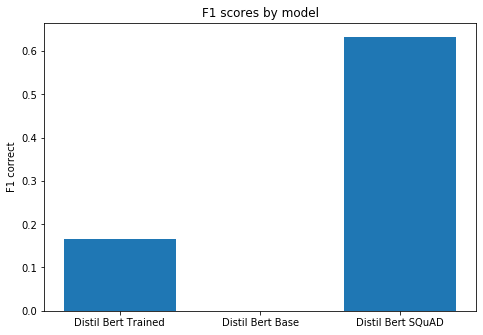

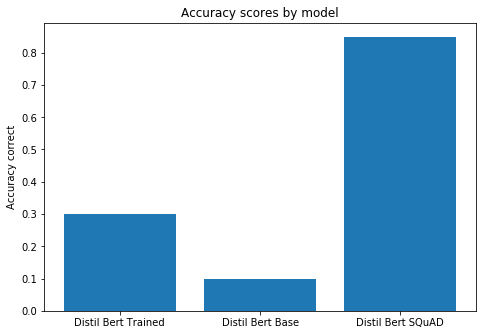

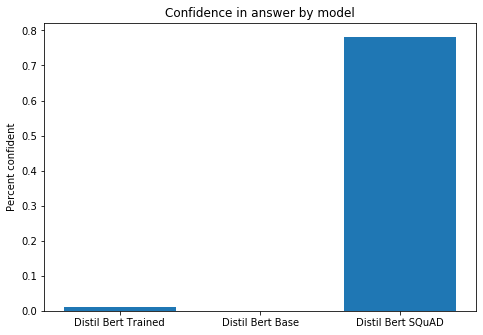

In [216]:
import matplotlib.pyplot as plt

models = ['Distil Bert Trained', 'Distil Bert Base', 'Distil Bert SQuAD']
f1_scores = [10/60,0/60,38/60]
accurancy_scores = [18/60,6/60,51/60]
percent_scores = [0.009452289873540092,0.0005253525706696867,0.7826526670406262]

fig_f1 = plt.figure()
ax = fig_f1.add_axes([0,0,1,1])
ax.bar(models,f1_scores)
ax.set_ylabel('F1 correct')
ax.set_title('F1 scores by model')
plt.show()

fig_accuracy = plt.figure()
ax = fig_accuracy.add_axes([0,0,1,1])
ax.bar(models,accurancy_scores)
ax.set_ylabel('Accuracy correct')
ax.set_title('Accuracy scores by model')
plt.show()

fig_percent = plt.figure()
ax = fig_percent.add_axes([0,0,1,1])
ax.bar(models,percent_scores)
ax.set_ylabel('Percent confident')
ax.set_title('Confidence in answer by model')
plt.show()